# Project 4: Question Answering on Squad
## CS4740/5740 Fall 2020

### Project Submission Due: Monday, December 21, 11:59pm
Please submit a **pdf file** of this notebook on **Gradescope**, and **ipynb** on **CMS**. For instructions on generating pdf and ipynb files, please refer to the pinned Piazza post @695.



Name: Komukill Loganathan

Netid: kl866


This assignment is to be done **on your own**, i.e., without any teammate.

# Notes

---

1. Please read through the entire notebook before you start coding. That might inform your code structure.
2. Google colab does **not** provide good synchronization; we do not recommend multiple people to work on the same notebook at the same time.




# Overview

---

In this project you will develop NLP models for question-answering tasks. Specifically, you will train models on the SQuAD 2.0 dataset which contains questions on text segments from Wikipedia. The dataset aims to measure the reading comprehension capabilities of machines. Some examples from the main paper are given below. For Project 4, the task is divided into two parts. First, you will decide on a model by yourself and train it on this task. Secondly, you will fine-tune a pretrained model. 




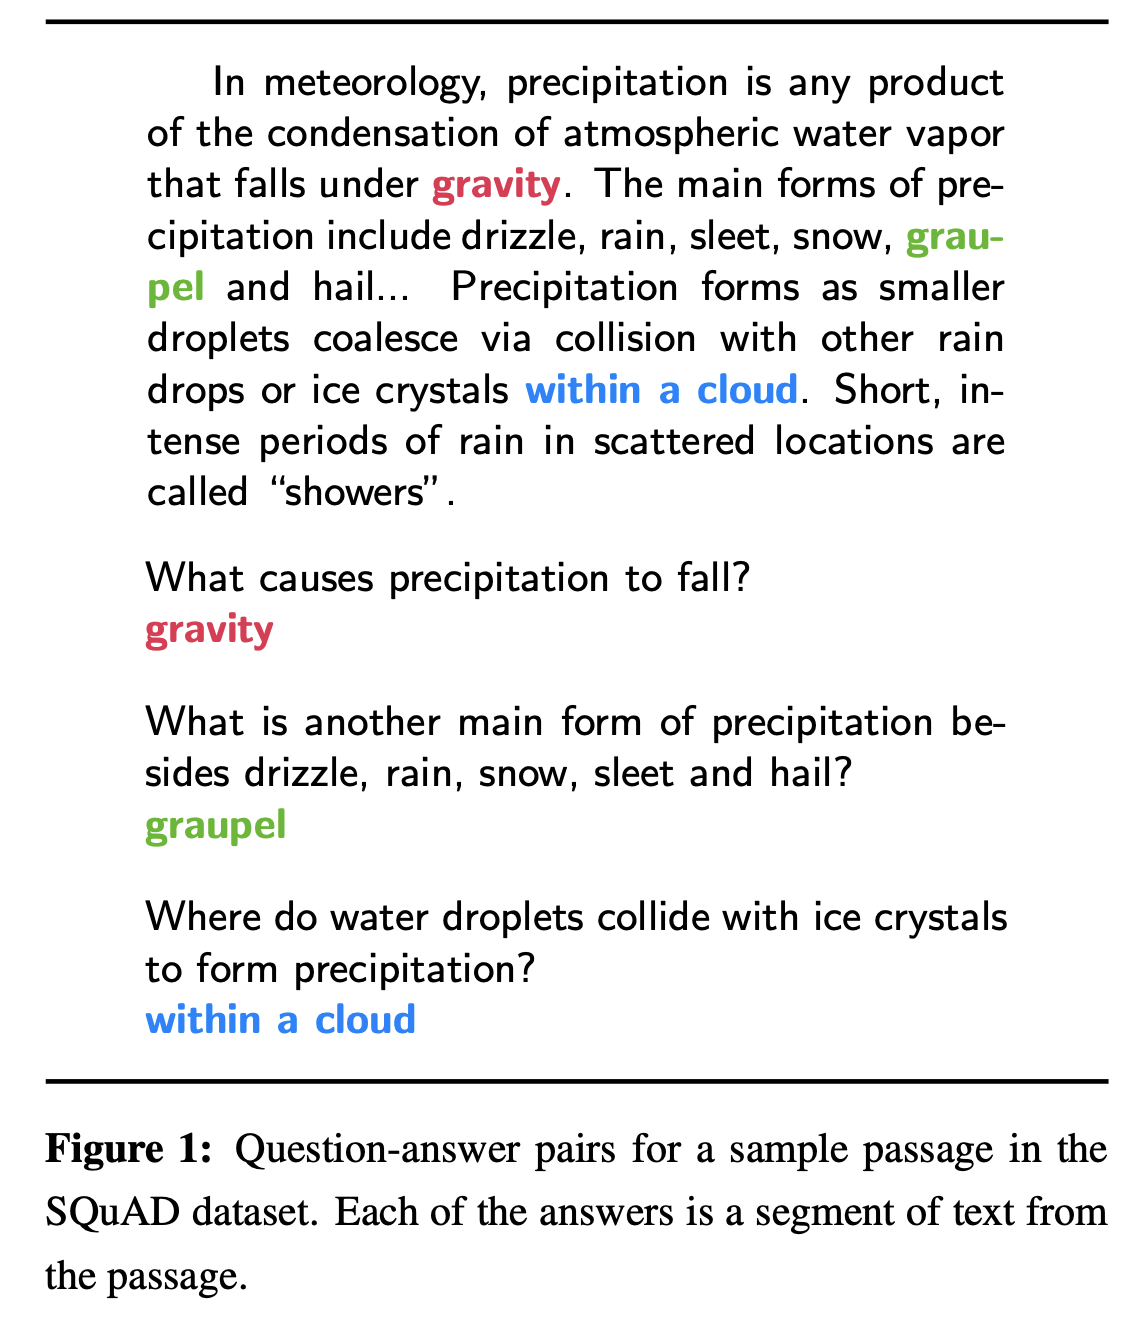

# Task and dataset

---

Obtain the data from [here](https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json). You also may consider doing so in a code block below.

```bash
!wget https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json
```

This gives you the dataset containing about 130,319 examples. You should split this into a **train** and **validation** dataset as in Project 2.


In [ ]:
!wget https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json

In [ ]:
!pip install transformers

In [2]:
import collections
import json
import string
import re

import numpy as np
import transformers
import random

In [3]:
# load json file
data = json.load(open("train-v2.0.json"))
data = data["data"]

In [ ]:
# data exploration

from matplotlib import pyplot as plt

print("Num of docs:", len(data))
min_par = len(data[0]["paragraphs"])
max_par = len(data[0]["paragraphs"])
q_count = []
impossible_q = []
span_length = []
unanswerable_ex = []
for i in range(len(data)):
  num_par = len(data[i]["paragraphs"])
  if num_par > max_par:
    max_par = num_par
  if num_par < min_par:
    min_par = num_par
  for p in range(num_par):
    q_count.append(len(data[i]["paragraphs"][p]['qas']))
    imp_q = 0
    for q in range(q_count[-1]):
      if len(data[i]["paragraphs"][p]['qas'][q]['answers']) != 0:
        span_length.append(len(data[i]["paragraphs"][p]['qas'][q]['answers'][0]['text']))
      else:
        span_length.append(0)
      
      if data[i]["paragraphs"][p]['qas'][q]["is_impossible"]:
        imp_q += 1
        dic = {}
        dic['question'] = data[i]["paragraphs"][p]['qas'][q]["question"]
        dic['context'] = data[i]["paragraphs"][p]['context']
        unanswerable_ex.append(dic)
    impossible_q.append(imp_q)
print("Minimum number of paragraphs:", min_par)
print("Maximum number of paragraphs:", max_par)

Num of docs: 442
Minimum number of paragraphs: 10
Maximum number of paragraphs: 149


Text(0, 0.5, 'Count')

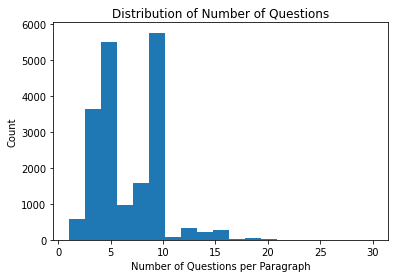

In [ ]:
import math

bins = np.linspace(math.ceil(min(q_count)), 
                   math.floor(max(q_count)),
                   20)
plt.hist(q_count, bins=bins)
plt.title('Distribution of Number of Questions')
plt.xlabel('Number of Questions per Paragraph')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

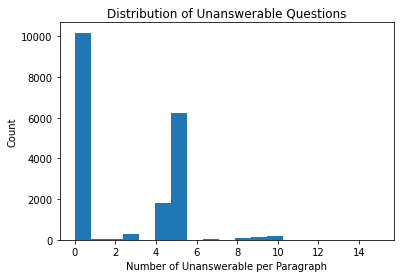

In [ ]:
bins = np.linspace(math.ceil(min(impossible_q)), 
                   math.floor(max(impossible_q)),
                   20)
plt.hist(impossible_q, bins=bins)
plt.title('Distribution of Unanswerable Questions')
plt.xlabel('Number of Unanswerable per Paragraph')
plt.ylabel('Count')

In [ ]:
print("Maximum number of unanswerable question:", max(impossible_q))
print("Minimum number of unanswerable question:", min(impossible_q))
unans_q_rate = [impossible_q[i]/q_count[i] for i in range(len(impossible_q))]
print("Maximum rate of unanswerable question:", max(unans_q_rate))
print("Minimum rate of unanswerable question:", min(unans_q_rate))
print("Average unasnwerability rate:", sum(unans_q_rate)/len(unans_q_rate))

Maximum number of unanswerable question: 15
Minimum number of unanswerable question: 0
Maximum rate of unanswerable question: 1.0
Minimum rate of unanswerable question: 0.0
Average unasnwerability rate: 0.24633609886330987


In [ ]:
print("Total unasnwerable questions:", sum(impossible_q))
print("Total questions:", sum(q_count))

Total unasnwerable questions: 43498
Total questions: 130319


In [ ]:
# exploring some unanswerable questions
random.shuffle(unanswerable_ex)

for ex in range(len(unanswerable_ex[:10])):
  print("Example", ex)
  print("Context:\n", unanswerable_ex[ex]['context'])
  print("Question:", unanswerable_ex[ex]['question'])
  print("")

Example 0
Context:
 Bermuda's economy is based on offshore insurance and reinsurance, and tourism, the two largest economic sectors. Bermuda had one of the world's highest GDP per capita for most of the 20th century and several years beyond. Recently, its economic status has been affected by the global recession. It has a subtropical climate. Bermuda is the northernmost point of the Bermuda Triangle, a region of sea in which, according to legend, a number of aircraft and surface vessels have disappeared under supposedly unexplained or mysterious circumstances. The island is in the hurricane belt and prone to severe weather. However, it is somewhat protected from the full force of a hurricane by the coral reef that surrounds the island.
Question: What is the Bermuda Triangle the northernmost point of?

Example 1
Context:
 Antarctica (US English i/æntˈɑːrktɪkə/, UK English /ænˈtɑːktɪkə/ or /ænˈtɑːtɪkə/ or /ænˈɑːtɪkə/)[Note 1] is Earth's southernmost continent, containing the geographic S

Maximum answer span length: 239
Minimum answer span length: 0


Text(0, 0.5, 'Count')

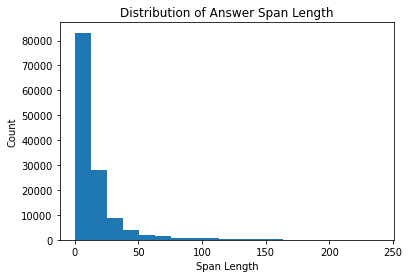

In [ ]:
print("Maximum answer span length:", max(span_length))
print("Minimum answer span length:", min(span_length))

bins = np.linspace(math.ceil(min(span_length)), 
                   math.floor(max(span_length)),
                   20)
plt.hist(span_length, bins=bins)
plt.title('Distribution of Answer Span Length')
plt.xlabel('Span Length')
plt.ylabel('Count')

### Q1: Initial data observations
What are your initial observations after you explore the dataset?

**Answer:**

There are 442 documents. Each document has multiple paragraphs, where each paragraph has its own set of questions, answerability, and answers. The minimum number of paragraphs any document could have is 10 and the maximum is 149. The distributions of number of questions for each paragraph, the number of unanswerable questions for each paragraph, and the answer span length are plotted above. 

For each paragraph, the average rate of unanswerable questions is 0.24. There are 43498 unanswerable questions in the total 130319 questions.

To explore the types of unanswerable questions, some example questions along with their context paragraph are printed out.

In one example, the question "_In Christianity what is Bramen considered?_" for the context of God in different religions seems to incorporate a term "Bramen" (spelled incorrectly in the question) from the Brahman concept of Hinduism to frame a question about Christianity. The expected answer type is an entity/explanation but the two named entities (religion and god name) are not related, and hence, this question is unanswerable.

Another example associated with the context on Yellow Emperor, the question "_What early adopter and developer is no longer associated with Confucianism?_" incorporates the term Confucianism that shows up in the context once. But, the context paragraph itself is not about confucianism nor anyone who is no longer associated with confucianism. The semantic of the question is completely unrelated to the semantic of the context paragraph which talks about various different people. 

Next, the context on fossil and biodiversity talks about how scientists disagree on fossils and differences in biodiversity across time but the question "_Why are some scientists uncertain about the diversification of life?_" asks an explanation/reason for why some scientists have uncertainty. The reasons for the different views of scientists (read: extra explanations) are not described in the context paragraph. So, this question is unanswerable because there is no information about why the information given in the paragraph is as such.

Finally, in one other example, the question "_When did the party's performance tank in local elections?_" seeks a specific time as an answer. The context paragraph talks about the improvement of the performance of a political party whereas the question asks about the decline in performance, which is not discussed in the paragraph at all. Hence, ths question is unanswerable because there is no information available.

From these 4 examples discussed - and the few that are printed above - we see that some questions in the dataset are unanswerable because either there is no information available to answer the question as the question addresses an unknown issue or an unrelated issue, or it connects different unrelated parts of the context paragraph to ask a nonsensical question.

The two metrics we will be using are **exact match** and **F1**. The exact match metric measures the percentage of predictions that match any one of the ground truth answers **exactly**. The F1 score is a looser metric, which measures the average overlap between the prediction and ground truth answer.

The F1 metric on answers is defined as:

$$F_1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

where $Precision$ is:
$$Precision = \frac{TP}{TP + FP} = \frac{\text{# of matching tokens}}{\text{# of predicted tokens}}$$

and $Recall$ is:
$$Recall = \frac{TP}{TP + FN} = \frac{\text{# of matching tokens}}{\text{# of gold tokens}}$$

and $TP$ refers to the number of true positives; $FP$ is the number of false positives; and $FN$ is the number of false negatives. (See Jurafsky & Martin Ch. 4.7).

These are then also averaged with the "has answer" prediction where we replace the individual question-answer pair score with a 1 if it correctly predicts that the question is not answerable, and keep the original score otherwise.

### Q1.1: The metrics

How much time does it take to compute these metrics? When will these metrics correlate well/poorly with human judgement of answer quality? Please implement the metric yourself.


**Answer**: 

Computing exact match takes O(n) time for each output where n is the length of the a_gold or a_pred, whichever is shorter. This is because this metric is an all or nothing metric, such that if at least one character differs between a_gold and a_pred, we get a score of 0. So, we need to go through the predicted output and the gold output at the same time. 

Computing the f1 score for each output takes time O(n^2) because to find the number of matching tokens between the predicted output and the golden output, we need to check each word in one string with the set of words in the other string. 

F1 score is likely to correlate better with human judgement because it takes into account the possibility of one-off errors in determining the span of answers. Humans are able to identify that the semantics of the answer does not change much just by the addition or omission of one or two words in the span of answer, unless the omission is the main answer keyword itself. In that case, the F1 score itself will be bad.

Exact match score on the other hand correlates very poorly with human judgement because it is an all-or-nothing metric. If there is even a character level difference between the predicted and golden outputs, the score is 0. Humans don't judge answers like that as we are able to discern the semantics of the answer even if there was a small difference between the predicted and golden outputs. 

In [4]:
# Some potentially useful helper functions for the metrics
def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)

def white_space_fix(text):
    return ' '.join(text.split())

def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

def lower(text):
    return text.lower()

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

In [5]:
# Another batch of helper functions, feel free to modify as needed
def apply_no_ans_threshold(scores, na_probs, qid_to_has_ans):
    """apply_no_ans_threshold applies the no-answer threshold (or mapping) to
    the no-ans probabilities/predictions.

    :param scores: A mapping of qid to the f1 or em score
    :type scores: dict[qid: str, score: float]
    :param na_probs: A mapping of qid to the no answer prediction/probability
    :type na_probs: dict[qid: str, score: float]
    :qid_to_has_ans: A mapping of qid to answerability
    :type qid_to_has_ans: dict[qid: str, answerability: bool]
    :returns: A mapping of qid to new scores accounting for answerability
    :rtype: dict[qid: str, score: float]
    """
    new_scores = {}
    return new_scores

def make_eval_dict(exact_scores, f1_scores, qid_list=None):
    """make_eval_dict makes a dictionary from the individual scores of qa pairs.
    
    :param exact_scores: Mapping of qid to the em score
    :type exact_scores: dict[qid: str, score: float]
    :param f1_scores: Mapping of qid to f1 score
    :type f1_scores: dict[qid: str, score: float]
    :param qid_list: List of qid's to aggregate, used to separate HasAns and
        NoAns scores for better analysis of models
    :type qid_list: List[qid: str]
    :returns: mapping of relevant evaluation metrics to their scores
    :rtype: OrderedDict[value: str, score: float]
    """
    return collections.OrderedDict([
        ("exact", 0.),
        ("f1", 0.),
        ("total", 0.),
    ])

def merge_eval(main_eval, new_eval, prefix):
    """merge_eval is a helper to merge two outputs of make_eval_dict.

    This is useful for cases when we want to have the aggregate scores, but also
    want to look at the scores for HasAns and for NoAns. Using make_eval_dict,
    we can take only those that have an answer, compute and merge with the
    original eval_dict.

    :param main_eval: The main evaluation dictionary that you report from
    :type main_eval: dict[value: str, score: float]
    :param new_eval: The new evaluation dictionary that you want to merge in
    :type new_eval: dict[value: str, score: float]
    :param prefix: The prefix you want attached to the new_eval scores.
        For example, HasAns as a prefix can be used to get HasAns_f1.
    :type prefix: str
    :returns: combination of main_eval and new_eval with prefix on new_eval keys
    :rtype: OrderedDict[value: str, score: float]
    """
    for k in new_eval:
        main_eval['%s_%s' % (prefix, k)] = new_eval[k]

In [6]:
# metric implementation here
def compute_exact(a_gold, a_pred):
  return int(a_gold == a_pred)

def compute_f1(a_gold, a_pred):
  # tokenize arguments
  a_gold = get_tokens(a_gold)
  a_pred = get_tokens(a_pred)

  # check unanswerability and return immediately if so
  if len(a_gold) == 0 and len(a_pred) == 0:
    return 1
  if len(a_gold) == 0 and len(a_pred) != 0:
    return 0
  
  # get num of matching tokens
  matching = 0
  for t in a_gold:
    if t in a_pred:
      matching += 1

  if matching == 0:
    return 0
  
  precision = matching / len(a_pred)
  recall = matching / len(a_gold)

  f1 = 2 * (precision * recall) / (precision + recall)
  return f1

# Model 1: Pick your own model

---

In this part of the project you will implement a model to perform well on the SQuAD dataset. The features that you use are entirely up to you. As always, a good strategy is to work through lots of examples from the training data to determine what types of features would be most useful. You are **NOT** allowed to use (i) deep contextualized pre-trained language models (e.g. ELMo, GPT, BERT) since they will be covered in Part B, or (ii) any existing code written for the SQUAD task. Otherwise, feel free to re-use any code you have written for previous projects in the class as well as **general** ML/NLP tools (e.g., PyTorch, spaCy). Please use the code block below to code, prototype, and test your language model:

Code of Academic Integrity:  We encourage collaboration regarding ideas, etc. However, please **do not copy code from online or share code with other students**. We will be running programs to detect plagiarism.

In [7]:
# preprocess data for model 1

def remove_punc2(text):
  exclude = set('!"#&\'()*+,-./:;<=>?@[\\]^_`{|}~')
  return ''.join(ch for ch in text if ch not in exclude)

def tokenize(s):
  if not s:
    return []
  return white_space_fix(remove_articles(remove_punc2(lower(s)))).split()

# find index position of answer in tokenized context
def find_sublist(lst, sublist, q):
  for i in range(len(lst)):
    try:
      if lst[i] == sublist[0] and lst[i:i+len(sublist)] == sublist:
        return i
    except:
      continue
  return -1

# preprocess data to tokenize context, question, and answer and determine answerability
# returns list of tuples of questions and context: 
# [(id, context [list of tokenized strings], question [list of tokenized strings], answerability [1 or 0], answer [ list of tokenized strings]), ...]
def preprocess_data(squad):
  q_and_a = []
  for article in squad:
    for paragraph in article['paragraphs']:
      context = tokenize(paragraph['context'])
      for qas in paragraph['qas']:
        question = tokenize(qas['question'])
        hasAns = int(not qas['is_impossible'])
        qid = qas['id']
        answer = [0]*len(context)
        if hasAns:
          tok_answer = tokenize(qas['answers'][0]['text'])
          sub_idx = find_sublist(context, tok_answer, qas['answers'])
          for i in range(sub_idx, sub_idx + len(tok_answer)):
            answer[i] = 1
        qa = (qid, context, question, hasAns, answer)
        q_and_a.append(qa)
  return q_and_a

In [8]:
qa_data = preprocess_data(data)

In [67]:
import random
import math

# shuffle qa data
random.shuffle(qa_data)

In [68]:
# split train and validation sets 90-10
sep = math.floor(len(qa_data) * 0.9)
train_set = qa_data[:sep]
val_set = qa_data[sep:]

print(len(train_set), "training questions and", len(val_set), "validation questions")

117287 training questions and 13032 validation questions


In [69]:
# get pre-trained GloVe dataset - 50 dimension
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

glove_path = os.path.join(os.getcwd(), "drive", "My Drive", "CS4740", "Project3", "p3-cs4740-2020fa","glove.twitter.27B.50d.txt")
glove = {}
with open(glove_path, 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        glove[word] = vector

Mounted at /content/drive


In [70]:
import torch
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [71]:
# Lambda to switch to GPU if available
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"
get_device()

'cuda:0'

In [72]:
# Your implementation here

# initializing vectorizer to vectorize feature dictionaries list
dv = DictVectorizer()

# extract features
def extract_features(train_qa, include_labels = True):
  # features - pos, q_embed_avg, word_embed_avg, exact_match
  feat_lst = []
  label_lst = []
  for (id, context, question, hasAns, answer) in train_qa:

    # find wh-question word & calculate embedding of keywords
    q_embed = np.zeros(50)
    question_word = ""
    for token in question:
      # if token in ["who", "when", "what", "how", "why", "which", "where", "whose", "whom"]:
      #   question_word = token
      #  q_embed += glove[question_word]
      # if token not in stop_words:
      if token in glove:
        q_embed += glove[token]
    
    context_pos = nltk.pos_tag(context)
    
    for i in range(len(context)):
      # get window of 5 words
      word_dict = {}
      # if i < 3:
      #   window_5 = context[0:5]
      # elif i > len(context)-2:
      #   window_5 = context[len(context)-5:]
      # else:
      #   window_5 = context[i-2:i+3]
      # window_embed = np.zeros(50)
      # for word in window_5:
      #   if word in glove:
      #     window_embed += glove[word]
      
      # window_embed = np.reshape(window_embed, (1,-1))
      # q_embed = np.reshape(q_embed, (1,-1))

      # word_dict["cos_sim"] = cosine_similarity(window_embed, q_embed)
      word_dict["pos"] = context_pos[i][1]
      # word_dict["q_word"] = question_word
      # q_embed_avg = 0
      # for idx in range(50):
      #   #name = "q_embed" + str(idx)
      #   q_embed_avg += q_embed[idx]
      # q_embed_avg /= 50
      word_dict["q_embed_avg"] = np.average(q_embed)
      if context[i] in glove:
        word_embed = glove[context[i]]
        # word_embed_avg = 0
        # for idx in range(50):
        #   # name = "word_embed" + str(idx)
        #   word_embed_avg += word_embed[idx]
        # word_embed_avg /= 50
        word_dict["word_embed_avg"] = np.average(word_embed)
      else:
        word_dict["word_embed_avg"] = 0.0
      # word_dict["q_embed"] = q_embed
      # word_dict["q_word_rep"] = glove[question_word]
      word_dict["exact_match"] = context[i] in question

      if include_labels:
        feat_lst.append((word_dict, answer[i]))
      else:
        feat_lst.append(word_dict)
        label_lst.append(answer[i])

  if include_labels:  
    return feat_lst
  else:
    return feat_lst, label_lst


In [73]:
# extract features in batch to avoid RAM crash or timeout

batch_size = 1000
start = 0

train_features_logit = []
train_labels = []

while start < len(train_set):
  if start % 10000 == 0:
    print(start)
  train_feat, train_lab = extract_features(train_set[start:start+batch_size], include_labels = False)
  train_features_logit.extend(train_feat)
  train_labels.extend(train_lab)
  start += batch_size

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000


In [74]:
# use SGDClassififer for model and train in batches
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import pickle

In [75]:
batches = 1485
batch_size = 8500
clf = SGDClassifier(loss='hinge') # SVM loss function classifier

In [76]:
# transform features (list of dictionary) to be compatible for a classifier that takes in a vectorized input
X = dv.fit_transform(train_features_logit)

In [78]:
# train classifier by partially fitting each batch to avoid RAM issues
for i in range(batches):
  if i % 100 == 0:
    print("Batch", i)
  start = i*batch_size
  end = min(i*batch_size + batch_size, len(train_features_logit))
  clf.partial_fit(X[start:end], train_labels[start:end], classes=np.unique(train_labels))

Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
Batch 600
Batch 700
Batch 800
Batch 900
Batch 1000
Batch 1100
Batch 1200
Batch 1300
Batch 1400


In [79]:
# model_save_name = 'SGDclassifier-P4.pt'
# path = F"/content/gdrive/My Drive/CS4740/{model_save_name}" 
# torch.save(clf.state_dict(), path)

model_save_name = 'SGDclassifier-P4.pickle'
path = F"/content/drive/MyDrive/CS4740/{model_save_name}" 

clf_path = open(path, 'wb')
pickle.dump(clf, clf_path)
clf_path.close()

In [18]:
model_save_name = 'SGDclassifier-P4.pickle'
path = F"/content/drive/MyDrive/CS4740/{model_save_name}" 

# check saved pickle model
with open(path, 'rb') as f:
  clf = pickle.load(f)

# clf2.predict(X)

In [80]:
pred = clf.predict(X)

In [81]:
# evaluate training
running_EM = 0.0
running_F1 = 0.0

EM_dict = {0:0.0, 1:0.0}
F1_dict = {0:0.0, 1:0.0}
total_dict = {0:0, 1:0}

idx = 0
for i in range(len(train_set)):
  (id, context, question, hasAns, answer) = train_set[i]
  end = idx + len(answer)

  ans_lst = []
  for j in range(len(answer)):
    if answer[j] == 1:
      ans_lst.append(context[j])

  pred_lst = list(pred[idx:end])
  pred_lst_extract = []
  for j in range(len(answer)):
    if pred_lst[j] == 1 : 
      pred_lst_extract.append(context[j])

  if i < 10:
    print("Example", i)
    print("Context\n", context)
    print("Question", question)
    print("Correct answer", " ".join(ans_lst))
    print("Predicted answer", " ".join(pred_lst_extract))
    print("")

  EM = compute_exact(" ".join(ans_lst), " ".join(pred_lst_extract))
  F1 = compute_f1(" ".join(ans_lst), " ".join(pred_lst_extract))
  
  running_EM += EM
  running_F1 += F1
  EM_dict[hasAns] += EM
  F1_dict[hasAns] += F1
  total_dict[hasAns] += 1
  idx = end

print("-----")
print("Average exact match - valid:", running_EM/len(train_set))
print("Average F1 score - valid:", running_F1/len(train_set))
print("")
for i in [0,1]:
  print("answerable", i)
  print("Average exact match -", i, ":", EM_dict[i]/total_dict[i])
  print("Average F1 match -", i, ":", F1_dict[i]/total_dict[i])
  print("")

Example 0
Context
 ['movement', 'to', 'translate', 'english', 'and', 'european', 'texts', 'transformed', 'arabic', 'and', 'ottoman', 'turkish', 'languages', 'and', 'new', 'words', 'simplified', 'syntax', 'and', 'directness', 'came', 'to', 'be', 'valued', 'over', 'previous', 'convolutions', 'educated', 'arabs', 'and', 'turks', 'in', 'new', 'professions', 'and', 'modernized', 'civil', 'service', 'expressed', 'skepticism', 'writes', 'christopher', 'de', 'bellaigue', 'with', 'freedom', 'that', 'is', 'rarely', 'witnessed', 'today', 'no', 'longer', 'was', 'legitimate', 'knowledge', 'defined', 'by', 'texts', 'in', 'religious', 'schools', 'interpreted', 'for', 'most', 'part', 'with', 'stultifying', 'literalness', 'it', 'had', 'come', 'to', 'include', 'virtually', 'any', 'intellectual', 'production', 'anywhere', 'in', 'world', 'one', 'of', 'neologisms', 'that', 'in', 'way', 'came', 'to', 'characterize', 'infusion', 'of', 'new', 'ideas', 'via', 'translation', 'was', 'darwiniya', 'or', 'darwinism

### Q2 : Explain your  implementation

Q2.1: Explain here your implementation (e.g. **which algorithms/data structures** you used). Make clear which parts were implemented from scratch vs. obtained via an existing package. 

**Answer:** 

For Part 1, I am creating a classifier model that takes in a word-level feature set and word-level label (0 or 1) that indicates if the current word is in the answer span of a question. For the SQuAD dataset that has both answerable and unanswerable questions, I am breaking down each question-answer data for each context to be of the form context-question-answer such that each pair of question and answer has a context saved with them. Then, I break down the context of each piece of the data processed to token-level and assign a label to each word of the context for the associated question such that the label is 0 if the word is not in the answer span, or 1 if the word is in the answer span of the question. I prepare this by creating a large list of tuples, where the tuple has 5 elements: qid, the context, the question, the answerability of the question, and the answer. This is done by looping over the SQuAD dataset and building a new list.

Then, I extract a set of features for each word in the context for each corresponding context for each question-answer pair in the dataset. To extract the features, I use a pretrained 50-dimension embeddings GloVe dataset downloaded to get some word embeddings. I also use numpy library to do some calculations in the feature extraction phase. I use the nltk library to get POS-tags for words as well. Other features are implemented from scratch and these are explained in Q2.3.

After extracting the features and getting the labels, I now have an input representation where the features is a list of feature dictionaries, where there is one element in the list for every word in every context for every question-answer pair. I also have a list of labels such that each label in the list corresponds to the feature dictionary in the features list at the same index. 

Then, I transform the feature dictionary list I created using sklearn's DictVectorizer to obtain a vectorized representation of the list. I then use sklearn's SGDClassifier with the loss function set up for 'hinge' so that support vector machine (SVM) classifier is used for the classification. I train this classifier using the word-level vectorized feature list and the list of labels.

To save the trained model and/or load a saved model, I use pickle library. 

---


Q2.2: Explain and motivate any design choices providing the intuition behind them (e.g. which methods you used for your implementation, why?).

**Answer:**

I decided to use a classifier to model a question-answering system on the token level such that the classifier produces a 0 or 1 label to indicate whether a context word will be present in the answer span for the question associated. I used this method because the problem of answering questions given a context and a question can be modeled as a classification problem. Instead of using two classifiers to determine the answerability of a question and another to determine the answer span, I used one classifier and combine both tasks into one. As described in Q2.1, the intuition is that if a question is unanswerable, then all the words in the context associated with the question will be assigned a label of 0. And so, a prediction of all 0s for all the words in a context will indicate an unanswerable question. If a question is answerable, then all the words in the answer span will be labeled 1 and the rest of the words in the context will have label 0. This is a straight forward model to build that is not as intensive on training time and resource. 

For the feature extraction, I used a pretrained GloVe dataset because this dataset gives a more universal set of word embeddings that would capture the meaning of the words much better than getting word embeddings on the fly using a different library. In addition to reducing training resource dependence, using GloVe also ensures that the meanings of all of the words for any context or short questions are accurately captured, which may not be the case if a function is used to create the embeddings for the given context.

I used an SGDClassifier with hinge loss function, i.e. a linear SVM loss function, as opposed to Logistic Regression or any other classifier, with the intuition that the SVM classifier would try to maximize the separation between both of the possible labels and with that, would be able to distinguish between words that would be in the answer span and words that will not be in the answer span much better, given the features that encode question semantic.

I also extracted features as well as trained the classifier in batches to ensure that the RAM is not overloaded given the size of the train dataset. 

---

Q2.3: What features did you use and why? Please motivate your choices.

**Answer:** 

I used part-of-speech (POS) tag of current context word as it will give some insight into the type of word the current context word is. This is because POS tag can be related to the semantic of the question and the potential answer type expected based on the type/meaning of the question asked.

I also used exact-match as a boolean feature where this feature is True if the exact current context word is in the question or False if it is not in the question. This feature is chosen because a word is more likely to be part of the answer if it is in the question and a boolean feature indicating the presence of such words will be a good indicator for the classifier.

The question embedding is also used as a feature but due to training resource constraint and RAM issues, the question embedding feature used is a compressed version of the entire embeddings of all the words in the question sequence. I total up the embeddings of each word in the question and then find the average of this cumulative embeddings numpy array to get a single float value to be the feature for question embeddings, called q_embed. While this is not the best way to represent the semantic of a question for a QA-model, RAM and time constraints as well as availability of training resources compelled me to take up this compressed version of embeddings. Including even this version of question embeddings is in the hopes of representing the meaning of the question in some ways as the total and average value of the question words embeddings would still have some correlation with the semantic of the question.

Similarly, another feature I chose is the average value of the numpy array embedding of the current context word, also in the hopes of capturing the semantic of the word despite the RAM and training resource constraints.

I was only able to use these 4 features with the RAM availability. Adding any more features or doing ablation study by removing one of these in favor of adding other features in mind does not work well with the RAM. 



## Validation Step



In [82]:
# extract valid features in batches
batch_size = 1000
start = 0

valid_features_logit = []
valid_labels = []

while start < len(val_set):
  if start % 10000 == 0:
    print(start)
  val_feat, val_lab = extract_features(val_set[start:start+batch_size], include_labels = False)
  valid_features_logit.extend(val_feat)
  valid_labels.extend(val_lab)
  start += batch_size

0
10000


In [83]:
# transforms validation input
X_valid = dv.fit_transform(valid_features_logit)

In [85]:
# predict
pred_valid = clf.predict(X_valid)

In [87]:
# evaluate validation
running_EM = 0.0
running_F1 = 0.0

EM_dict = {0:0.0, 1:0.0}
F1_dict = {0:0.0, 1:0.0}
total_dict = {0:0, 1:0}

idx = 0
for i in range(len(val_set)):
  (id, context, question, hasAns, answer) = val_set[i]
  end = idx + len(answer)

  ans_lst = []
  for j in range(len(answer)):
    if answer[j] == 1:
      ans_lst.append(context[j])

  pred_lst = list(pred_valid[idx:end])
  pred_lst_extract = []
  for j in range(len(answer)):
    if pred_lst[j] == 1 : 
      pred_lst_extract.append(context[j])

  if i < 10:
    print("Example", i)
    print("Context\n", context)
    print("Question", question)
    print("Correct answer", " ".join(ans_lst))
    print("Predicted answer", " ".join(pred_lst_extract))
    print("")

  EM = compute_exact(" ".join(ans_lst), " ".join(pred_lst_extract))
  F1 = compute_f1(" ".join(ans_lst), " ".join(pred_lst_extract))
  
  running_EM += EM
  running_F1 += F1
  EM_dict[hasAns] += EM
  F1_dict[hasAns] += F1
  total_dict[hasAns] += 1
  idx = end

print("-----")
print("Average exact match - valid:", running_EM/len(val_set))
print("Average F1 score - valid:", running_F1/len(val_set))
print("")
for i in [0,1]:
  print("answerable", i)
  print("Average exact match -", i, ":", EM_dict[i]/total_dict[i])
  print("Average F1 match -", i, ":", F1_dict[i]/total_dict[i])
  print("")

Example 0
Context
 ['after', 'american', 'revolutionary', 'war', 'broke', 'out', 'in', '1776', 'connecticut', 'colonial', 'government', 'ordered', 'construction', 'of', 'black', 'rock', 'fort', 'to', 'be', 'built', 'on', 'top', 'of', 'older', '17thcentury', 'fort', 'to', 'protect', 'port', 'of', 'new', 'haven', 'in', '1779', 'during', 'battle', 'of', 'new', 'haven', 'british', 'soldiers', 'captured', 'black', 'rock', 'fort', 'and', 'burned', 'barracks', 'to', 'ground', 'fort', 'was', 'reconstructed', 'in', '1807', 'by', 'federal', 'government', 'on', 'orders', 'from', 'thomas', 'jefferson', 'administration', 'and', 'rechristened', 'fort', 'nathan', 'hale', 'after', 'revolutionary', 'war', 'hero', 'who', 'had', 'lived', 'in', 'new', 'haven', 'cannons', 'of', 'fort', 'nathan', 'hale', 'were', 'successful', 'in', 'defying', 'british', 'war', 'ships', 'during', 'war', 'of', '1812', 'in', '1863', 'during', 'civil', 'war', 'second', 'fort', 'hale', 'was', 'built', 'next', 'to', 'original', '

### Q3: Results Analysis

Q3.1: Explain here how you evaluated the models. Summarize the performance of your system and any variations that you experimented with on the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis. 

**Answer:**

I split the SQuAD dataset into a train set and a validation set. After creating the feature extraction function, preprocessing the train data, and training the SGDClassifier with the extracted features of train data set, I used the validation set to evaluate the model.

I first extracted the features of the validation set. Then, I transformed the feature set to be compatible to be used for the SGDClassifier. Then, I predicted the labels for the word-level transformed feature set. Then, I used a loop to loop through the predictions alongside the actual labels of each question-answer to extract the predicted answer span and evaluate it against the gold answer span given in the dataset. The evaluation is done using the compute_exact and compute_f1 functions coded earlier. Both of these computations are done at the answerability levels as well as the overall level. The model always predicts 0 for all input feature set and the reasons for this is explained in the next questions. The results of these metric calculations are as follows:

Metric Level | Exact Match score | F1 score
--- | --- | ---
Answerable Questions | 0.0 | 0.0
Unanswerable Questions | 1.0 | 1.0
Overall - All Questions  | 0.3364 |0.3364

Here, the overall exact match and f1 scores reflect the rate of unanswerable questions. The SQuAD dataset has 33% unanswerable questions and as such, the F1 score reflects the correct prediction of all unanswerable questions.


---


Q3.2: When did the system work well? When did it fail?  Any ideas as to why? How might you improve the system?

**Answer:**

The system works well in identifying the unanswerable questions and this is only because it is always predicting unanswerability for all contexts and questions by labelling all context words to be 0, which means that all words are labelled as not being in the answer span. This is the failure of the system. The system fails to identify the answerability or answer span for any question and context by labeling all words in the contexts as 0. This is because there is a substantial class imbalance in the dataset and the way the model is built makes the classifier look at an overwhelmingly large amount of 0s as labels for the data and a very small amount of 1s as labels for the answer span of answerable questions. 

This is because, while there are only 33% of unanswerable questions in the dataset, the context words in all the answerable questions are also largely labelled as 0 because the majority of answer spans is less than 10 characters, which can make up at most 2 or 3 words in a context that could have about 200 words. Hence, the model is seeing an overwhelming majority of 0 labels and a very small amount of 1 labels. It is also likely that the features extracted are not as descriptive of the questions, contexts, and potential answer spans.

One way to improve this model is by setting a class weightage to let the classifier weigh 1 labels much more than 0 labels to mitigate some of the class imbalance. This could help the classifier assign 1 labels at a higher probability than the current 0 probability of assignment. Another way the model could be improved is by extracting a better set of features for each context word. If RAM issues and Google Colab timeouts were not issues that I face, I would add features to represent the word embeddings of each context word in full as well as each question sequence word embeddings in full. I would also add a feature for cosine similarity between a window of words from the current context word and the question asked (this could not be added because of RAM issues as adding this feature causes the RAM to crash). Another way to improve is by including features on the surrounding context words and their potential to be in the answer span because right now the classifier labels each context word without taking into account the previous labels and by only looking at the current word and question. Adding features of likelihood of previous and/or next word to be in the answer span as well as the context of the current context word with respect to the surrounding words could improve the model too. This is because if a previous word is in the answer span it is quite likely for the current word to be in the answer span too if the current word is a named entity and the previous word is a grammatical function word like preprositions. The same logic applies to the next word.

---


Q3.3: What is the effect of the method used for handling unknown words? Note: Even if you choose to skip over unknown words, that is still a _method_ of handling out-of-vocabulary terms.

**Answer:**

Since the model uses a context token-level classifier, all tokens in a context gets a feature dictionary to represent that input to be passed to the classifier for training and prediction and as such, out-of-vocabulary terms are not ignored from the input for the classifier at all. The only time out-of-vocabulary terms are encountered is during the feature extraction phase where a pretrained 50-dimension GloVe dataset is used to obtain word embeddings for the current context words as well as the tokens in the question to represent the semantics of each of these respectively. In the case that a context word unknown to the GloVe dataset is encountered, the feature for word_embedding for that word is simply ignored and that feature will not be present in that word's feature dictionary. Similarly, if a word in a question sequence is unknown, the embedding of that word is ignored but the rest of the known words of the question sequence are still taken into account for the summation of the embeddings array, which will then be used to get an average value for the question embedding as described above. The rationale behind this is that, if the GloVe dataset does not have an embedding for a word, then the word is either not a valid dictionary word, a typo, non-word symbols, or proper nouns. These are rare occurrences in a context paragraph and as such, I decided to ignore these from being given a word_embedding feature as the meaning of these words will not affect the model too much and if it is an important entity name, the exact match feature will be given a higher importance by the classifier. I also decided to ignore these words from the question embed calculation as well for the same reason and also because the semantic and expected answer type of a question can be captured by the calculation of the rest of the words in the question sequence. 

Overall, the rationale is that these rare out-of-vocabulary terms will not affect the main model much because each word in the context does get a representation to be passed to the classifier. Only certain features within the representation get ignored by the feature extraction phase but the representation will still be captured by other features of these rare words. 


# Part B: Fine-tune a Pre-trained Language Model

---

In this part, the goal is to build a strong system by fine-tuning a pre-trained language model. You can use **any** public code, **any** pre-trained language models, and **any** hardware resources -- anything other than code specifically written for SQUAD. A reasonable baseline F1 score to aim for is around 0.7.



In [5]:
# Your implementation here
from tqdm import tqdm
import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from transformers import DistilBertTokenizerFast, DistilBertModel

import math

In [6]:
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"
get_device()

'cuda:0'

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
# preprocess data 

def bert_preprocess(squad):
  contexts = []
  questions = []
  answers = []
  for article in squad:
    for paragraph in article['paragraphs']:
      context = paragraph['context']
      for qas in paragraph['qas']:
        question = qas['question']
        if len(qas['answers']) == 0:
          answer = {}
          answer['answer_start'] = None
          answer['text'] = ""
          answer['answer_end'] = None
        else:
          answer = qas['answers'][0]
          answer['answer_end'] = answer['answer_start'] + len(answer['text'])

          # sometimes squad answers are off by a character or two – fix this
          # used huggingface docs as a guide
          start_idx = answer['answer_start']
          end_idx = answer['answer_end']
          gold_text = answer['text']
          if context[start_idx:end_idx] == gold_text:
              answer['answer_end'] = end_idx
          elif context[start_idx-1:end_idx-1] == gold_text:
              answer['answer_start'] = start_idx - 1
              answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
          elif context[start_idx-2:end_idx-2] == gold_text:
              answer['answer_start'] = start_idx - 2
              answer['answer_end'] = end_idx - 2

        contexts.append(context)
        questions.append(question)
        answers.append(answer)

  return contexts, questions, answers

contexts, questions, answers = bert_preprocess(data)

In [9]:
print(contexts[0])
print(questions[0])
print(answers[0])

Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
When did Beyonce start becoming popular?
{'text': 'in the late 1990s', 'answer_start': 269, 'answer_end': 286}


In [10]:
# shuffle processed data
tgt = list(zip(contexts, questions, answers))
random.shuffle(tgt)
contexts, questions, answers = zip(*tgt)

In [11]:
print(contexts[0])
print(questions[0])
print(answers[0])

The earliest writers on sexual orientation usually understood it to be intrinsically linked to the subject's own sex. For example, it was thought that a typical female-bodied person who is attracted to female-bodied persons would have masculine attributes, and vice versa. This understanding was shared by most of the significant theorists of sexual orientation from the mid nineteenth to early twentieth century, such as Karl Heinrich Ulrichs, Richard von Krafft-Ebing, Magnus Hirschfeld, Havelock Ellis, Carl Jung, and Sigmund Freud, as well as many gender-variant homosexual people themselves. However, this understanding of homosexuality as sexual inversion was disputed at the time, and, through the second half of the twentieth century, gender identity came to be increasingly seen as a phenomenon distinct from sexual orientation. Transgender and cisgender people may be attracted to men, women, or both, although the prevalence of different sexual orientations is quite different in these two

In [12]:
# split train and validation sets 90-10
sep = math.floor(len(contexts) * 0.9)
train_contexts = contexts[:sep]
train_questions = questions[:sep]
train_answers = answers[:sep]

val_contexts = contexts[sep:]
val_questions = questions[sep:]
val_answers = answers[sep:]

print(len(train_questions), "training questions and", len(val_questions), "validation questions")

117287 training questions and 13032 validation questions


In [13]:
tokenize = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenize(train_contexts, train_questions, truncation=True, padding=True)

In [14]:
# get start and end positions - used HuggingFace docs as a guide
def get_positions(encodings, answers):
  start_positions = []
  end_positions = []
  for i in range(len(answers)):
    if answers[i]['answer_start'] is None:
      start_positions.append(0)
      end_positions.append(0)
    else:
      start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
      end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))
    if start_positions[-1] is None:
      start_positions[-1] = 0
    if end_positions[-1] is None:
      end_positions[-1] = 0

  return start_positions, end_positions

train_start, train_end = get_positions(train_encodings, train_answers)

In [15]:
train_encodings.update({'start_positions': train_start, 'end_positions': train_end})

In [16]:
class DistilBertQA(nn.Module):
  def __init__(self):
    super(DistilBertQA, self).__init__()
    self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
    self.out = nn.Linear(768, 2)
    self.loss = CrossEntropyLoss()
  
  def load_model(self, save_path):
    self.load_state_dict(torch.load(save_path))
	
  def save_model(self, save_path):
    torch.save(self.state_dict(), save_path)

  def forward(self, input_ids, attention_masks, start_positions, end_positions):
    output = self.bert(input_ids=input_ids, attention_mask=attention_masks)
    probs = self.out(output[0])

    start, end = probs.split(1, dim=-1)
    start = start.squeeze(-1)
    end = end.squeeze(-1)

    out = (start, end) + output[2:]
    return out


In [ ]:
model = DistilBertQA()
model.to(get_device())

In [18]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-5)

In [19]:
# used huggingface docs as a guide to make Dataset
class SquadDataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings

  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

  def __len__(self):
    return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [21]:
def train(epoch, training_loader):
  model.train()
  for _,data in tqdm(enumerate(train_loader, 0)):
    ids = data['input_ids'].to(get_device())
    mask = data['attention_mask'].to(get_device())
    start = data['start_positions'].to(get_device())
    end = data['end_positions'].to(get_device())

    outputs = model(input_ids=ids, attention_masks=mask, start_positions=start, end_positions=end)

    optimizer.zero_grad()

    if len(start.size()) > 1:
      start = start.squeeze(-1)
    if len(end.size()) > 1:
      end = end.squeeze(-1)

    start_loss = model.loss(outputs[0], start)
    end_loss = model.loss(outputs[1], end)
    loss = (start_loss + end_loss) / 2

    if _ % 1000 == 0:
      print(f'Epoch: {epoch}, Loss:  {loss}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [22]:
for epoch in range(2):
  train(epoch, train_loader)
  model_save_name = "bertQAModel-epoch"+ str(epoch) +".pth"
  model.save_model(model_save_name)

0it [00:00, ?it/s]

Epoch: 0, Loss:  6.350811958312988


1000it [09:15,  1.78it/s]

Epoch: 0, Loss:  2.070889949798584


2000it [18:35,  1.79it/s]

Epoch: 0, Loss:  1.7019548416137695


3000it [27:55,  1.78it/s]

Epoch: 0, Loss:  1.0528461933135986


4000it [37:16,  1.78it/s]

Epoch: 0, Loss:  0.9284483790397644


5000it [46:36,  1.78it/s]

Epoch: 0, Loss:  0.7104133367538452


6000it [55:57,  1.78it/s]

Epoch: 0, Loss:  2.1356558799743652


7000it [1:05:17,  1.78it/s]

Epoch: 0, Loss:  1.1739107370376587


8000it [1:14:38,  1.79it/s]

Epoch: 0, Loss:  1.255656123161316


9000it [1:23:59,  1.78it/s]

Epoch: 0, Loss:  1.7948768138885498


10000it [1:33:20,  1.78it/s]

Epoch: 0, Loss:  1.7016956806182861


11000it [1:42:40,  1.79it/s]

Epoch: 0, Loss:  1.0935020446777344


11729it [1:49:28,  1.79it/s]
0it [00:00, ?it/s]

Epoch: 1, Loss:  0.8873167037963867


1000it [09:20,  1.78it/s]

Epoch: 1, Loss:  0.36590731143951416


2000it [18:40,  1.80it/s]

Epoch: 1, Loss:  1.1921943426132202


3000it [28:00,  1.78it/s]

Epoch: 1, Loss:  1.0932698249816895


4000it [37:20,  1.78it/s]

Epoch: 1, Loss:  0.8447867035865784


5000it [46:40,  1.79it/s]

Epoch: 1, Loss:  0.9847941398620605


6000it [56:00,  1.79it/s]

Epoch: 1, Loss:  0.6545904874801636


7000it [1:05:20,  1.79it/s]

Epoch: 1, Loss:  1.0681462287902832


8000it [1:14:41,  1.78it/s]

Epoch: 1, Loss:  1.7295057773590088


9000it [1:24:01,  1.79it/s]

Epoch: 1, Loss:  0.8097293972969055


10000it [1:33:21,  1.79it/s]

Epoch: 1, Loss:  0.7405993938446045


11000it [1:42:42,  1.79it/s]

Epoch: 1, Loss:  0.9370244741439819


11729it [1:49:30,  1.79it/s]


In [23]:
model_save_name = "bertQAModel-round2.pth"
path = F"/content/drive/MyDrive/CS4740/{model_save_name}" 
model.save_model(model_save_name)

In [24]:
# coded using example solution.py as guide
def validate(question, context):
  encoding = tokenize(context, question, max_length=512, truncation=True, padding=True)
  input_ids = torch.tensor([encoding['input_ids']]).to(get_device())
  attn_mask = torch.tensor([encoding['attention_mask']]).to(get_device())
  start, end = model(input_ids=input_ids, attention_masks=attn_mask, start_positions=None, end_positions=None)

  # Search the input_ids for the first instance of the `[SEP]` token.
  sep_index = encoding['input_ids'].index(tokenize.sep_token_id)

  answer_start = torch.argmax(start)
  answer_end = torch.argmax(end)

  tokens = tokenize.convert_ids_to_tokens(encoding['input_ids'])

  if answer_start >= len(tokens):
    return "", False

  # print("start", answer_start, "end", answer_end, "tokens", len(tokens))

  answer = tokens[answer_start]

  if answer == '[CLS]':
    return "", False

  for i in range(answer_start + 1, min(answer_end + 1, len(tokens))):

    # If it's a subword token, then recombine it with the previous token.
    if len(tokens[i])>2 and tokens[i][0:2] == '##':
      answer += tokens[i][2:]

    # Otherwise, add a space then the token.
    else:
      answer += ' ' + tokens[i]

  # print('Answer: "' + answer + '"')

  return answer, True

In [36]:
# validate

running_EM = 0.0
running_F1 = 0.0

EM_dict = {0:0.0, 1:0.0}
F1_dict = {0:0.0, 1:0.0}
total_dict = {0:0, 1:0}

i_hasans = 0
i_noans = 0
i_opp = 0
i_opp2 = 0

for idx in range(len(val_questions)):
  ans, hasAns = validate(val_questions[idx], val_contexts[idx])

  em = compute_exact(val_answers[idx]['text'], ans)
  f1 = compute_f1(val_answers[idx]['text'], ans)

  running_EM += em
  running_F1 += f1
  EM_dict[int(hasAns)] += em
  F1_dict[int(hasAns)] += f1
  total_dict[int(hasAns)] += 1
  if i_hasans < 3 and hasAns:
    boo = False if val_answers[idx]['answer_start'] is None else True
    print("Predicted Answerability", hasAns)
    print("True Answerability", boo)
    print("Context\n", val_contexts[idx])
    print("Question", val_questions[idx])
    print("Correct answer", val_answers[idx]['text'])
    print("Predicted answer", ans)
    print("")
    i_hasans+=1
  
  if i_noans < 3 and not hasAns:
    boo = False if val_answers[idx]['answer_start'] is None else True
    print("Predicted Answerability", hasAns)
    print("True Answerability", boo)
    print("Context\n", val_contexts[idx])
    print("Question", val_questions[idx])
    print("Correct answer", val_answers[idx]['text'])
    print("Predicted answer", ans)
    print("")
    i_noans+=1

  # print gold unanswerable but predicted answerable
  if i_opp < 3 and hasAns and val_answers[idx]['answer_start'] is None:
    boo = False if val_answers[idx]['answer_start'] is None else True
    print("Predicted Answerability", hasAns)
    print("True Answerability", boo)
    print("Context\n", val_contexts[idx])
    print("Question", val_questions[idx])
    print("Correct answer", val_answers[idx]['text'])
    print("Predicted answer", ans)
    print("")
    i_opp+=1

  # print gold answerable but predicted unanswerable
  if i_opp2 < 3 and not hasAns and val_answers[idx]['answer_start'] is not None:
    boo = False if val_answers[idx]['answer_start'] is None else True
    print("Predicted Answerability", hasAns)
    print("True Answerability", boo)
    print("Context\n", val_contexts[idx])
    print("Question", val_questions[idx])
    print("Correct answer", val_answers[idx]['text'])
    print("Predicted answer", ans)
    print("")
    i_opp2+=1

  

print("-----")
print("Average exact match - valid:", running_EM/len(val_answers))
print("Average F1 score - valid:", running_F1/len(val_answers))
print("")
for i in [0,1]:
  print("answerable", i)
  print("Average exact match -", i, ":", EM_dict[i]/total_dict[i])
  print("Average F1 match -", i, ":", F1_dict[i]/total_dict[i])
  print("")



Predicted Answerability True
True Answerability True
Context
 There was a linguistic predisposition to use such terms. The Romans had used them in near Gaul / far Gaul, near Spain / far Spain and others. Before them the Greeks had the habit, which appears in Linear B, the oldest known script of Europe, referring to the near province and the far province of the kingdom of Pylos. Usually these terms were given with reference to a geographic feature, such as a mountain range or a river.
Question The appearance of what culture using the terms appears in Linear B?
Correct answer the Greeks
Predicted answer greeks

Predicted Answerability False
True Answerability False
Context
 Most hunter-gatherers are nomadic or semi-nomadic and live in temporary settlements. Mobile communities typically construct shelters using impermanent building materials, or they may use natural rock shelters, where they are available.
Question Which communities do not live a nomadic or semi-nomadic life?
Correct answ

### Q4: Implementation Details

Q4.1: Explain here how you implemented the fine-tuning (e.g. which algorithms/data structures you used, what features are included). Make clear which parts were implemented from scratch vs. obtained via an existing package. 


**Answer:**

For this part, I fine-tuned a DistilBertModel from huggingface transformers library with the pretrained model "distilbert-base-uncased". I created a model that takes in a question and context and returns two arrays of probabilities, one the probability of each context word to be the start token and another the probability of each context word to be the end token, respectively. The answer span can then be determined by getting the index of the arrays of the start_probabilities and end_probabilities that have the largest probabilities. The words at the indices determined and all other words between these two indices make up the answer span.

To fine tune this model for a question answering task as I have described, I created a class that inherits the PyTorch neural network nn.Module class. I created a DistilBertModel in this class and added a Linear output layer from torch.nn to generate a pair of start and end token probabilities arrays. The pretrained Bert model has 768 hidden dimensions and I used this as the Linear layer input dimension, with an output dimension of 2 for 2 set of probabilities that I want to predict. I created a forward function in this NN model that takes in an input_ids tensor, attention_mask tensor, start_probabilties tensor, and end_probabilities tensor (The start and end probabiltiies are not used in the forward function - but I forgot that I forgot that I added them and trained the model with that - time constraints did not allow me to remove these and retrain the model). In the forward function, the bert layer is called with the input_ids argument and the attention_mask argument, found in the pretrained model. The Linear layer is applied on the first index of the output of this bert layer. From this linear layer's output, the start and end probabilities are split and returned. This is the basic model that was used.

To train this model, I first preprocessed the SQuAD dataset by splitting the contexts, questions, and answers to be separate lists such that the indices of a single set of question-context-answer data piece are the same across these 3 lists. 

Then, I added the character-level end_positions for the answer span for each answer in the answers list. The start and end positions for unanswerable questions were set to None. After this, I shuffled the dataset together (by zipping) and split them for a 90% training set and 10% validation set separation. The validation data will be used later when I evaluate the model, explained in Q5.1. To create the model from here, I use the train dataset.

After this, I used a DistilBertTokenizerFast pretrained tokenizer from huggingface transformer to tokenize and encode the train data. I added token level start positions and end positions in list representations in the encodings as new key and items to be used in the training phase later. The start and end positions for answerable questions were obtained by using the char_to_token function for BatchEncoding data type to get the token-level positions from the character-level positions in the answers dataset. If a question is unanswerable (i.e. start and end positions are None), the start and end positions were set to be the first token, i.e. the token corresponding to [CLS] tag, added by the encoder. Following this, I created a PyTorch Dataset representation to hold the train data encodings and loaded this Dataset into a DataLoader with a batch_size of 10. I used the HuggingFace documentation to guide me in preparing the train data to be used for my model.

Then, to train and further fine tune this model for a QA-task, I created a train function that takes in the train dataloader. I use the Adam optimizer from the PyTorch library for training. In the train function, I extract out the input_ids, attention_mask, start_positions, and end_positions of the current batch from the encodings of the tokenizer used on the train data. I use these to do a forward pass on the model. I get the output, which is a pair of arrays for start_probabilities and end_probabilities and calculate the loss before doing a backward pass. To calculate the loss, I first calculate the loss of the start_probabilities from the actual start_positions using a CrossEntropyLoss fuction from PyTorch saved with the model. I do the same to get end_probabilites loss. Then, I get the average loss of these two lossess and do a backward pass on this averaged loss. After this I do a step on the optimizer. I, of course, zero out the optimizer gradient at the beginning of each batch iteration.

The model is finetuned for question-answering task in this way. To train the fine-tuned model, I used 2 epochs with dataloader batch size 10 and an Adam optimizer learning rate of 3e-5. Using a small enough batch size and a good enough learning rate like this ensures that the RAM does not crash on Google Colab as well as a reasonable training time (~5 hours) to produce a reasonable model that performs fairly well. The learning rate of 3e-5 is a good rate as it gives a model that performs well that trains at a reasonable time.



### Q5: Results Analysis

Q5.1: Explain here how you evaluated the model. Summarize the performance of your system and any variations that you experimented with the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis. 

**Answer:**

Exact match and F1 scores are used to evaluate the model I finetuned. I calculated the average exact match and F1 scores for the overall validation dataset as well as the average in the answerability levels.

To evaluate the model, I constructed a validate function which is very similar to the solution.py file that was submitted to the autograder. The validate function takes in a question and a context and returns an answer string and a boolean value indicating the answerability of the question. If the answerability is False, then the answer string is just an empty string. 

Then, I loop over the validation set that was separated earlier. This validation set has a contexts list, a questions list, and an answers list where each element in these 3 lists at the same index are associated with one another. I call the validate function at each iteration of the loop for the corresponding context and question. I use the returned predicted answer string along with the gold answer from the validation answers list to get the exact match score and f1 score, implemented earlier. I then add these values to the running total variables of exact_match score and f1 score, both for the overall dataset level as well as the running totals broken down in terms of answerability. 

After looping through all the validation contexts and questions, I get the average of the exact match and F1 scores, both for the overall level as well as at the answerability levels.

The scores for the validation set are summarized in the following table:

Metric Level | Exact Match score | F1 score
--- | --- | ---
Answerable Questions | 0.2013 | 0.6443
Unanswerable Questions | 0.6801 | 0.6801
Overall - All Questions  | 0.4017 | 0.6593

From these scores, we can see that the model performs fairly well because it is not predicting all questions as unanswerable and they have prettyy good overall f1 score which is better correlated with human judgment as I have explained in the metrics section. For the unanswerable questions, the exact match and f1 scores are supposed to be the same because there is no token level calculations to be done. The model predicts more than half of the unanswerable questions right. For the answerable questions, the model has 0.20 exact match score but 0.64 f1 score, which means that the model does not give the exact answer needed for an unanswerable question most of the time but the answer string predicted generally includes most of the answer tokens needed for the golden output. There could be additional words and/or some truncation in the answers predicted.

Overall, the model has 0.40 exact_match score which is lower than the 0.65 f1 score but this means that the model predicts the answer spans correctly more than half of the time but the predicted answer itself may not be the exact gold answers. 

---

Q5.3: When did the system work well, when did it fail and any ideas as to why? How might you improve the system?

**Answer:**

Adding onto the scores analysis of the previous question, some example similariites and variations between the predicted answerability and the gold answerability as well as their corresponding gold and predicted answer spans are printed above at the validation phase along with the associated contexts and questions. 

From the scores alone, we can see that the model performs fairly well. The system works quite well in predicting unanswerability as the f1 and exact match scores are 0.68. The model also performs fairly well predicting answerability but it does not perform well in predicting the exact start and end positions of the gold answers. The system fails quite a bit when the predicted answer span is compared with the gold answer span, with an exact match score of 0.2. This means that the model is not learning the start and end positions of the answer spans in the context perfectly yet. But, the f1 score of answerable questions is 0.64 which is fairly good. This means that answer spans are predicted in a somewhat good manner, but these spans often include extra words, or are missing certain words needed to be in the gold answer span. 

Some examples of predictions can be discussed here to look at specific cases that work well and those that don't as much.

For example, for the answerable question "The appearance of what culture using the terms appears in Linear B?", the answer predicted "greeks" is the same as the gold answer "the greeks" semantically but the the exact match score would be 0 because the predicted answer is missing an article in the answer. The f1 score is affected such that it is not 1 even though semantically the answer predicted is right, there is only one matching token in between the predicted and gold answer. So, the model predicts answers well, as long as the semantic is right, but misses out on the grammatical aspects like articles which make the answers complete. 

Another example, for the answerable question "What releases formaldehyde?" about resins, the gold answer is "a resin" but the predicted answer is "a resin used for making non - wrinkle shirts" which is semantically correct as well but the predicted answer includes extra information which is not needed to answer this question. The model takes the entire noun phrase. So this model tends to include extra information that overcompletes an answer when the system only needs a short general answer.

One other example, for the question "How much had Spectre made in its first month in China?" with the context:

"`In China, it opened on 12 November and earned $15 million on its opening day, which is the second biggest 2D single day gross for a Hollywood film behind the $18.5 million opening day of Mission: Impossible – Rogue Nation and occupying 43% of all available screens which included $790,000 in advance night screenings. Through its opening weekend, it earned $48.1 million from 14,700 screens which is 198% ahead of Skyfall, a new record for a Hollywood 2D opening. IMAX contributed $4.6 million on 246 screens, also a new record for a three-day opening for a November release (breaking Interstellar's record). In its second weekend, it added $12.1 million falling precipitously by 75% which is the second worst second weekend drop for any major Hollywood release in China of 2015. It grossed a total of $84.7 million there after four weekends. Albeit a strong opening it failed to attain the $100 million mark as projected. `",

the context does not explicitly mention the name Spectre and the model learns and predicts that this question is not answerable because there is no mention of the word Spectre in the context but Spectre is a keyword in the question. The gold answer is that this question is answerable and the answer span is "$84.7 million". So, this model does not deduce an unrecognized entity in the context solely from the question, which I would say is a good prediction in itself. This is because the model is not deciding the answerability of the question by deciding what the context is talking about using the question itself when the main entity is not named.

Additionally, for the question "Sake, made with rice and fruit, was produced in China around which year?" whose context is 

"`The earliest known chemical evidence of barley beer dates to circa 3500–3100 BC from the site of Godin Tepe in the Zagros Mountains of western Iran. Some of the earliest Sumerian writings contain references to beer; examples include a prayer to the goddess Ninkasi, known as "The Hymn to Ninkasi", which served as both a prayer as well as a method of remembering the recipe for beer in a culture with few literate people, and the ancient advice (Fill your belly. Day and night make merry) to Gilgamesh, recorded in the Epic of Gilgamesh, by the ale-wife Siduri may, at least in part, have referred to the consumption of beer. The Ebla tablets, discovered in 1974 in Ebla, Syria, show that beer was produced in the city in 2500 BC. A fermented beverage using rice and fruit was made in China around 7000 BC. Unlike sake, mould was not used to saccharify the rice (amylolytic fermentation); the rice was probably prepared for fermentation by mastication or malting.`", 

the true answer is that this question is unanswerable but the model predicts that the question is answerable and gives the answer "7,000 BC". This likely happens because the question has a large chunk of tokens that match with the context sequence on China's fermented beverage and the word sake appears just two tokens away from this window of words about the Chinese beverage. The model likely assumes that the entire sequence including the word sake in the context answers the question and picks the answer. But, in reality, the question is combining two unrelated information and seeks a nonsensical answer because the context does not talk about sake that is made in China and the Chinese fermented beverage in the context is not sake. So, the model is not capturing the semantics of questions and contexts correctly when closely co-occuring unrelated words from the context are used in the question.

Along with these 4 instances, there are a few more predicted and gold answers printed at the validation phase, which shows that the model predicts clear cut questions for context that have unambigious semantics easily. But, when the questions asked combine unrelated entities from the context, especially if they occur close together, the model predicts incorrect answer span or predicts incorrect answerability. The model also, at this stage, predicts answers that include extra information about the answer, which are semantically correct but informationally redundant or unnecessary. The model also sometimes ignores grammatical additions like articles and such when predicting answers, which is again semantically right but not good for performance score.

To improve the system, the finetuned model can be trained for a few more epochs if the training resources are available. This will help the model learn the start probability and end probability better given the tokens of the context and the associated question. This will at the very least help with unanswerability detection as well as correct answer span detection.

Additionally, we can also use a larger pretrained Bert because right now I use bert base which has 768 hidden dimensions. If a larger bert pretrained model is used, the hidden dimension will be larger (about 1024 hidden dimensions) with a 24 encode layers, which is larger than the 13 layers in the bert base model. More information about the contexts and questions can be captured by a larger bert model that has a larger hidden dimension and the answerability as well as answer span detected would be more nuanced in such a model, especially if such model is trained for many epochs.

Another improvement that can be done is by using more than just the token_ids and attention_masks information from the encoded input to train the model as adding more information about the encoded information will make the model capture the patterns in the QA-task better. 





#Comparing the two models

---


### Q6:


Compare here your results for the two models. How are you evaluating their performance? Which of them performs better using this metric and how much better? 

**Answer:**

The performances of both of these models are evaluated by their exact match scores and f1 scores. From both of these scores, model 2, the finetuned bert model performs much better than model 1, the classifier. Model 1 predicts all questions as unanswerable by labeling all contexts words as not being in the answer span. So, at this state, model 1 is not predicting useful information at all. However, model 2 predicts a good number of unanswerable as well as answerable questions along with their answer spans. The difference in the overall exact match score between model 1 and model 2 is 0.0653, which may not seem much but model 1 is always predicting the unanswerable questions correctly as it is always predicting unanswerability while model 2 performs better but does not give the exact answers needed for the answerable questions.
The overall f1 score difference between model 1 and model 2 is 0.3589, which is a significant increase in f1 score from model 1 to model 2. Model 2 has a much better f1 score (almost double the score of model 1) because model 2 predicts a lot of answerable questions and has answer strings that match the gold answers quite a bit, even though not exactly.

The f1 score also more closely resembles human judgment than the exact score match. As seen in the model 2 analysis, model 2 is predicting mopst answer almost correctly, but the f1 score is lower because the model often adds or reduces words to the answer span which makes the answers not as accurate as the gold outputs. Model 1, however, is not predicting effectively as it is always outputting the same label for everything.

---

###Q7: Error Analysis
Do some error analysis. What are error patterns you observed one model making but not the other? Try to justify why/why not?

**Answer:**

The main error in model 1 is that it is always predicting 0 for all words, while model 2 is actually learning the task and gives better prediction as model 2 predicts both answerability and unanswerability for a large number of inputs. Model 1 makes this error all the time because of class imbalance as described in the evaluation section of model 1. The classifier sees an overwhelmingly large number of 0 labels and only a few 1 labels. So, the classifier learns that the probability that a word is in the answer span is much much lower than the probability that the word is not in the answer span for any question and context. 

Hypothetically if the classifier of model 1 were to perform really well and there is no class imbalance, then the classifier learns from the features used and the performance of the classifier would depend heavily on the features extracted and used to train the classifier. 

So, by default, model 2 performs much better and gives a better prediction. The error of model 2 is explained extensively in model 2 analysis. With the performance of model 1, model 2 always performs better at all times as the predictions of model 1 is not meaningful. Hence, the error analysis of model 2 alone is as described in part Q5.2.



# Gradescope Submission 
---




This time, we will actually be probing your model rather than you having to predict on the test set. We show an example in the appendix but you will need to upload a zip file that contains `solution.py`. This file will download your parameters via Google drive, load them into your model, and have a `predict` function that we will use.

The `predict` function takes in a `question` string and an `context` string identifies the words within the `context` that are the answer (if there is one) and also returns the answerability of the question. We give a sample within the appendix

### Q9: Competition Score
Include here your **team name** and the **screenshot** of your best score from Gradescope.

**Answer:** Team name is kl866

In [7]:
# from IPython.display import Image 
# from google.colab import drive
# import os
# drive.mount('/content/drive', force_remount=True)

# path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "p4-round2.png")
# Image(filename=path)

#Appendix
---


## Approximate Projected Point Breakdown

- Q1. Dataset observations (5)
- Q1.1 Implement and discuss the metric(s) (5)
- Q2. Implement your own model (20)
- Q3. Evaluate your own model (10)
- Q4. Implement finetuning (25)
- Q5. Evaluate finetuned model (10)
- Q6. Compare the results (5)
- Q7. Failure analysis (5)
- Q8. Predictions submission (5)
- Code quality (5)
- Page assignment and clarity (5)







## Gradescope Details

Below is a sample `solution.py` code to submit on gradescope. This is also available on Piazza! As it stands, it will not run but this is because the QA model is currently not defined. This is something you will need to write.

```python
import os
import pathlib
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import re

import requests
import torch
import transformers

directory = pathlib.Path(__file__).parent.absolute()

drive_path = "https://drive.google.com/file/d/1NbdW7rPuuCd6ij4bR_2yLL8zGvqfyVIb/view?usp=sharing"

gdrive_id = re.search("https://drive.google.com/file/d/(.*)/view\?usp=sharing", drive_path).group(1)
# print(f"GDrive ID: {gdrive_id}")

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


download_file_from_google_drive(gdrive_id, f"{str(directory / 'netid_parameters.zip')}")
print("Parameters downloaded")

proc = subprocess.Popen([f"unzip -o {str(directory / 'netid_parameters.zip')} -d {str(directory)}"], stdout = subprocess.PIPE, shell=True)

(out, error) = proc.communicate()
pathlib.Path(f"{str(directory / 'netid_parameters.zip')}").unlink()
pathlib.Path(f"{str(directory / 'netid_parameters')}").unlink()


get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"
model = BertQAModel.from_pretrained(str(directory / "netid_parameters" / "model")).to(get_device())
tokenizer = BertTokenizer.from_pretrained(str(directory / "netid_parameters" / "tokenizer"))

model.eval()
print("Model loaded")


def predict(question, context):
    '''predict uses your PCE model and predicts the answer and answerability

    Takes a `question` string and an `context` string (which contains the
    answer), and identifies the words within the `context` that are the
    answer, and if there is an answer

    :param question: The question to answer
    :type question: str
    :param context: The context in which to search for the answer
    :type context: str
    :return: A pair of (answer, hasAns) that represents the model's prediction
        on the answer and whether this question is answerable
    :rtype: Tuple[str, bool]
    '''
    with torch.no_grad():
        # ======== Tokenize ========
        # Apply the tokenizer to the input text, treating them as a text-pair.
        input_ids = tokenizer.encode(question, context, max_length=512, truncation=True,)

        # Report how long the input sequence is.
        # print('Query has {:,} tokens.\n'.format(len(input_ids)))

        # ======== Set Segment IDs ========
        # Search the input_ids for the first instance of the `[SEP]` token.
        sep_index = input_ids.index(tokenizer.sep_token_id)

        # The number of segment A tokens includes the [SEP] token istelf.
        num_seg_a = sep_index + 1

        # The remainder are segment B.
        num_seg_b = len(input_ids) - num_seg_a

        # Construct the list of 0s and 1s.
        segment_ids = [0]*num_seg_a + [1]*num_seg_b

        # There should be a segment_id for every input token.
        assert len(segment_ids) == len(input_ids)

        # ======== Evaluate ========
        # Run our example question through the model.
        start_scores, end_scores = model(torch.tensor([input_ids]).to(get_device()), # The tokens representing our input text.
                                        token_type_ids=torch.tensor([segment_ids]).to(get_device())) # The segment IDs to differentiate question from context

        # ======== Reconstruct Answer ========
        # Find the tokens with the highest `start` and `end` scores.
        answer_start = torch.argmax(start_scores.cpu())
        answer_end = torch.argmax(end_scores.cpu())

        # Get the string versions of the input tokens.
        tokens = tokenizer.convert_ids_to_tokens(input_ids)

        # Start with the first token.
        answer = tokens[answer_start]

        # Select the remaining answer tokens and join them with whitespace.
        for i in range(answer_start + 1, answer_end + 1):
            
            # If it's a subword token, then recombine it with the previous token.
            if tokens[i][0:2] == '##':
                answer += tokens[i][2:]
            
            # Otherwise, add a space then the token.
            else:
                answer += ' ' + tokens[i]

        # print('Answer: "' + answer + '"')

        return answer, True

```


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%%capture
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [8]:
%%capture
!cp 'drive/My Drive/Colab Notebooks/4740_FA20_p4.ipynb' ./

In [9]:
!jupyter nbconvert --to PDF "4740_FA20_p4.ipynb"

[NbConvertApp] Converting notebook 4740_FA20_p4.ipynb to PDF
[NbConvertApp] Support files will be in 4740_FA20_p4_files/
[NbConvertApp] Making directory ./4740_FA20_p4_files
[NbConvertApp] Making directory ./4740_FA20_p4_files
[NbConvertApp] Making directory ./4740_FA20_p4_files
[NbConvertApp] Writing 530859 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] CRITICAL | xelatex failed: [u'xelatex', u'./notebook.tex', '-quiet']
This is XeTeX, Version 3.14159265-2.6-0.99998 (TeX Live 2017/Debian) (preloaded format=xelatex)
 restricted \write18 enabled.
entering extended mode
(./notebook.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size11.clo))
(/usr/share/texlive/texmf-dist/tex